In [ ]:
# pip install --quiet scvi-tools

In [1]:
# !pip install scDREAMER
import scDREAMER

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scib
import louvain

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [4]:
import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [5]:
# setting seed for reproducibility
np.random.seed(666)
tf.set_random_seed(666)
random.seed(666)
tf2.random.set_seed(666)
tf2.keras.utils.set_random_seed(666)

In [6]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [7]:
gene_list = pd.read_csv("../R_macaque/labels/batch_labels_macaque_50.csv").iloc[:, 0].values
adata = adata[adata.obs.index.isin(gene_list) , :]
adata

View of AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [8]:
adata.obs['celltype'] = pd.read_csv("../R_macaque/labels/batch_labels_macaque_50.csv")['batch_labels'].values

In [9]:
# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'celltype']].head(100)

,batch,cell_type,celltype
index,,,
M1Fovea1_AAACCTGAGATATACG-1,M1Fovea1,DB3b,DB3b
M1Fovea1_AAACCTGCACCGTTGG-1,M1Fovea1,FMB,FMB
M1Fovea1_AAACGGGAGAAGGGTA-1,M1Fovea1,IMB,IMB
M1Fovea1_AAACGGGCAAATCCGT-1,M1Fovea1,DB5*,DB5*
M1Fovea1_AAACGGGCATGCGCAC-1,M1Fovea1,DB4,DB4
...,...,...,...
M1Fovea1_ACGAGCCAGAGATGAG-1,M1Fovea1,FMB,FMB
M1Fovea1_ACGAGCCCAACAACCT-1,M1Fovea1,DB6,DB6
M1Fovea1_ACGAGGAGTTCGGGCT-1,M1Fovea1,IMB,IMB


In [ ]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('./labels_for_new_methods/partially_annotated_batches_macaque_50_obs.csv')

In [ ]:
adata.write('./labels_for_new_methods/macaque_partially_annotated_batches_50.h5ad')

In [10]:
embeddings_dict = {}

## scDREAMER
scDREAMER takes h5ad file directly as input.


Leaning rate to use for small data vs large input data: 
learning_rate = {
    "Immune_Human": {"lr_ae": 0.0002, "lr_dis": 0.0007},  # Small Datasets
    "Human_Mouse": {"lr_ae": 0.0001, "lr_dis": 0.00001},
}  # Big Datasets >= 0.5 million cells

it does the data preprocessing by its own function: 
	•	read_h5ad: This function reads the data from an .h5ad file using Scanpy and performs several preprocessing steps:
	•	Normalization: Total counts per cell are normalized to 10,000.
	•	Log Transformation: A log transformation is applied to the data.
	•	Highly Variable Genes: The top 2,000 highly variable genes are selected based on the Seurat method, using the batch key for batch correction.
	•	Data Preparation: The data is then converted into a dense or sparse matrix, depending on sparseIP.
	•	One-Hot Encoding: Batch information and cell type labels are one-hot encoded, which will be used later in the model.
	•	load_gene_mtx: This function loads the dataset, processes it using read_h5ad, and prepares it for input into the model. It handles transformations, normalization, and returns the processed data along with labels and batch information.

Loading dataset
Preprocessing...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


here [ 4  8  9 ... 11 11  6]
Shape self.data_train: (30302, 2000)
Shape self.data_test: (30302, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2030), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 40), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ./labels_for_new_methods/macaque_partially_annotated_batches_50.h5ad ... 
Epoch : [0] ,  a_loss = 137.5824
Epoch : [10] ,  a_loss = 107.3265
Epoch : [20] ,  a_loss = 102.2757
Epoch : [30] ,  a_loss = 99.4381
Epoch : [40] ,  a_loss = 97.3844
Epoch : [50]

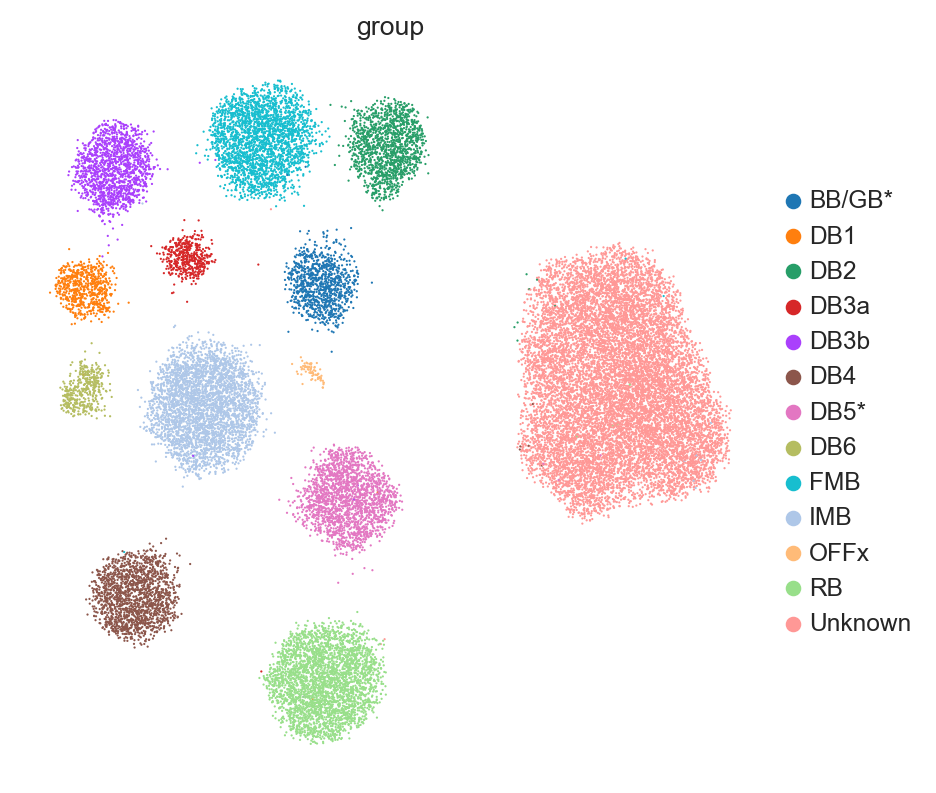

None


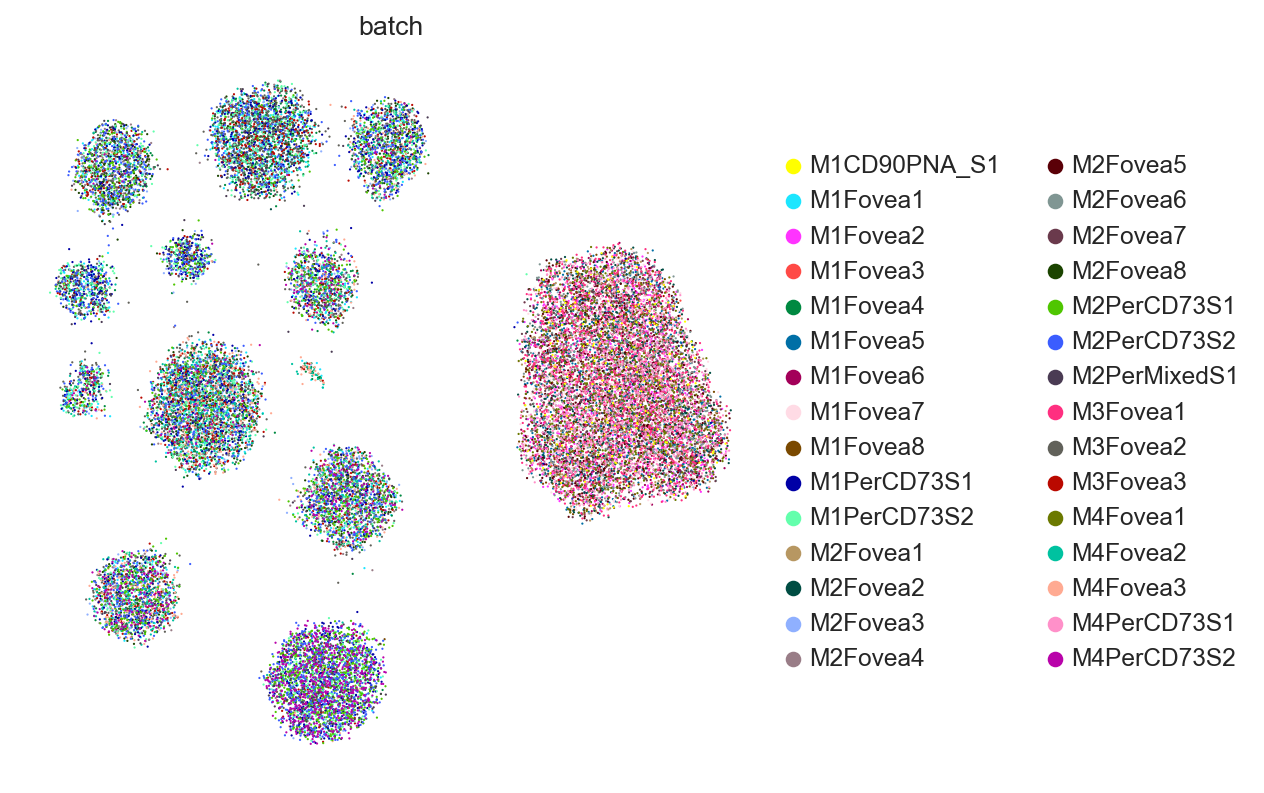

None


In [11]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "macaque_partially_annotated_batches_50"
dataset_path = "./labels_for_new_methods/macaque_partially_annotated_batches_50.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=200,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()

In [12]:
import pandas as pd
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/partially_annotated_batches_scdreamer_embeddings_macaque_50.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [13]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = adata.obsm['X_scDREAMER']

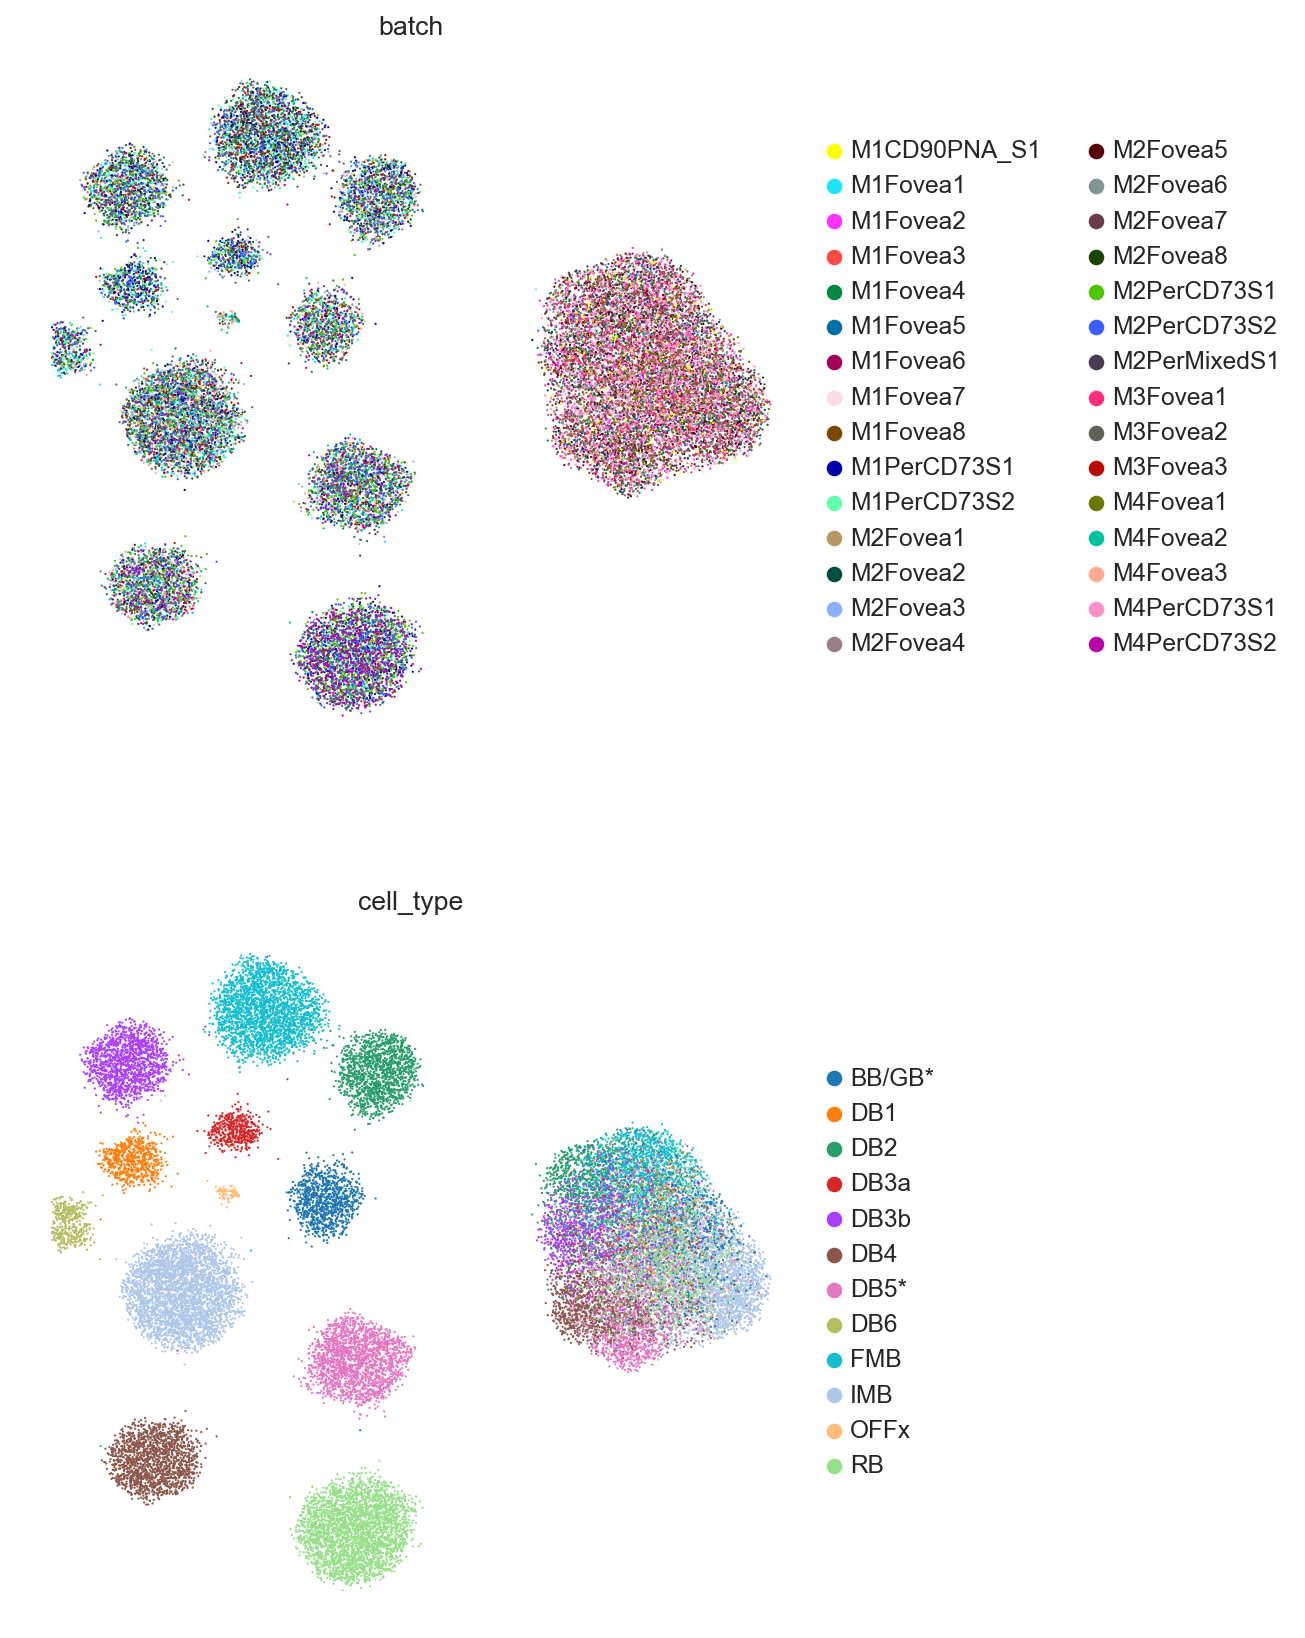

In [14]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# ItClust

In [15]:
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/partially_annotated_batches_macaque_itclust_embeddings_50.csv', index_col=0)
adata.obsm['X_ItClust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_ItClust")
sc.tl.umap(adata, min_dist=0.5)

In [16]:
# Collect embeddings
embeddings_dict["X_ItClust"] = adata.obsm['X_ItClust']

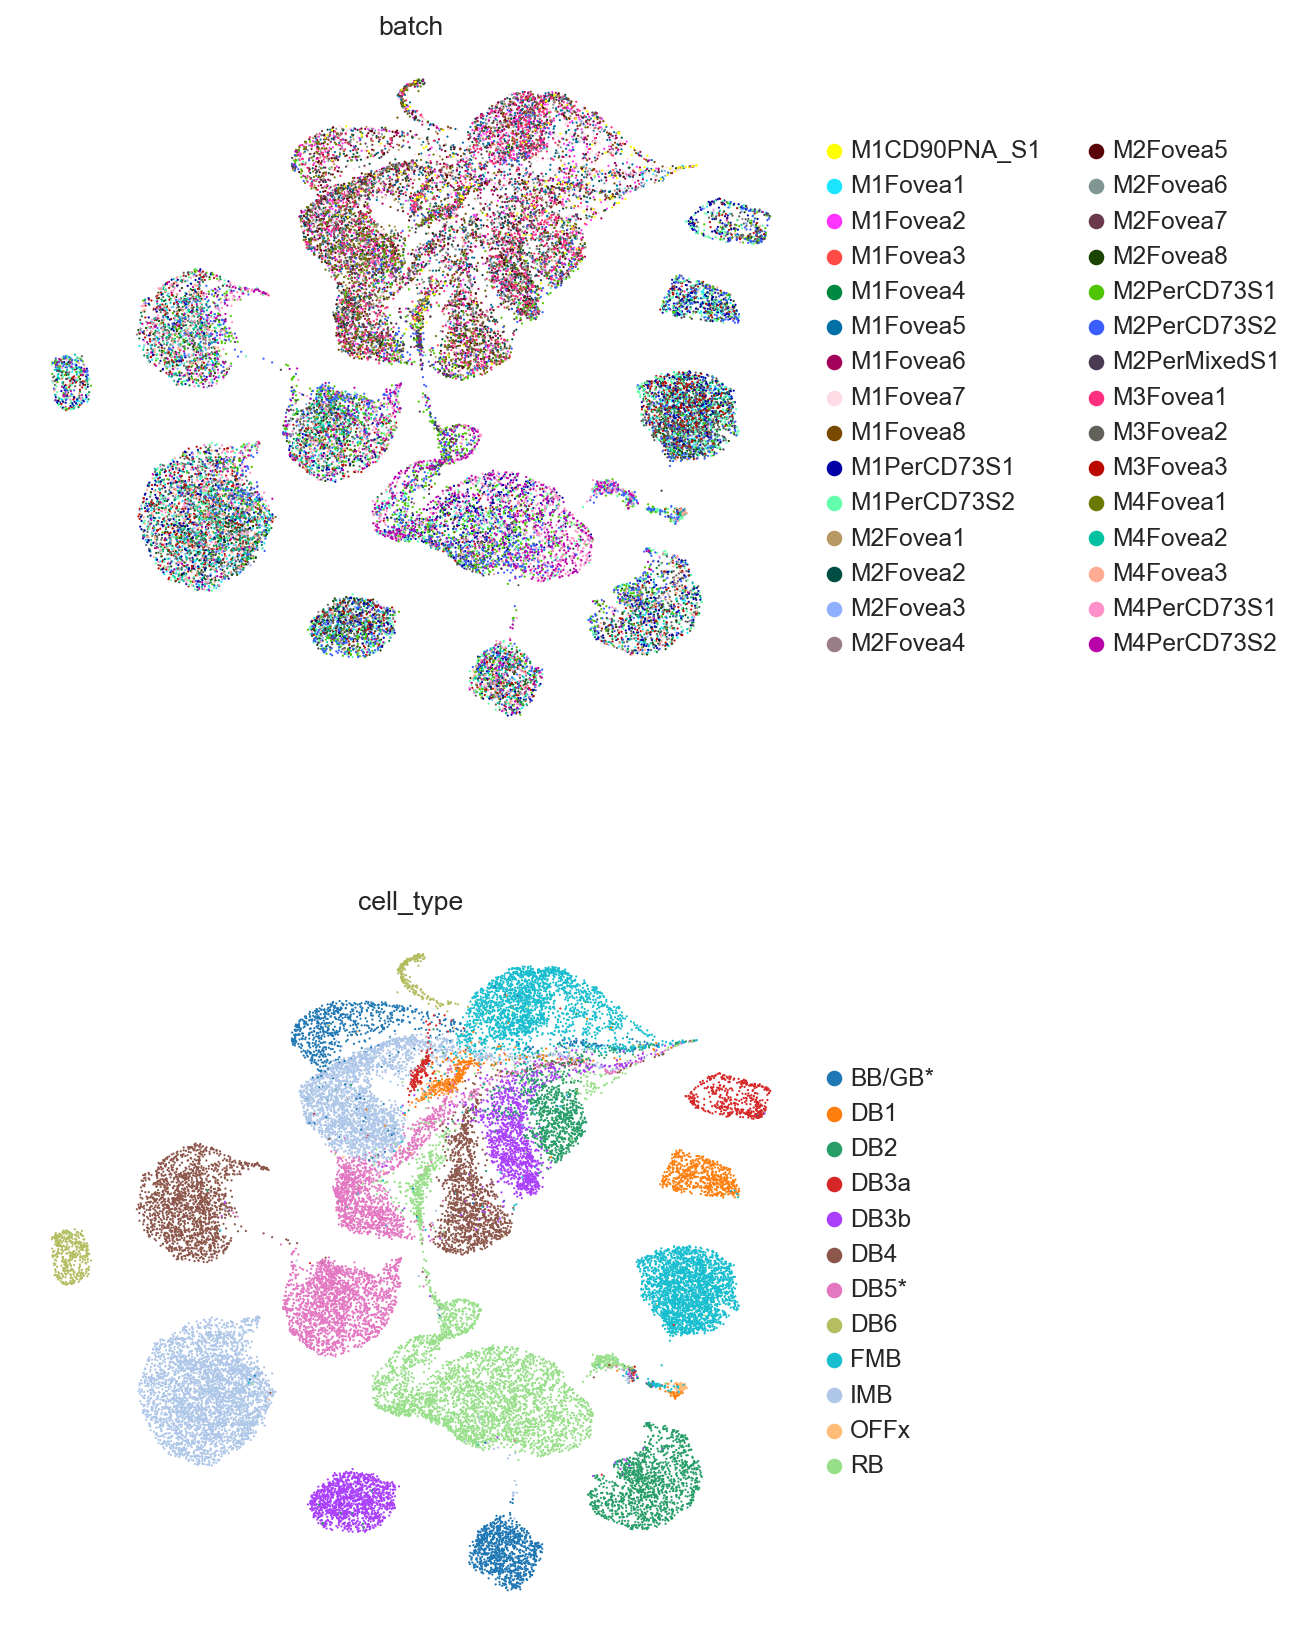

In [17]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [18]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_macaque_new_50.csv")
